In [2]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.datasets.samples_generator import make_blobs
except:
    from sklearn.datasets import make_blobs

%matplotlib inline

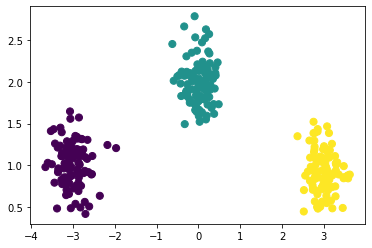

In [3]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

# One VS All

In [4]:
#Complete the methods fit, decision_function, and predict 

from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False
        
#11. Complete the methods fit, decision_function, and predict 
#from the OneVsAllClassifier in the skeleton code

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        #Your code goes here
        for y_i, est in enumerate(self.estimators):
            
            #For each y_i, create a binary class
            n_samples = len(y)
            y_binary = np.zeros(n_samples)
            idx = np.where(y == y_i)[0]
            y_binary[idx] = 1
            
            #Fit to the binary classification of y
            est.fit(X, y_binary)
        
        self.fitted = True  
        return self   

    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        #Determine number of samples n
        n = len(X)
        
        #Initialize array of zeroes for scores
        scores = np.zeros(n * self.n_classes)
        
        #Reshape decision function
        scores = scores.reshape(n, self.n_classes)
        
        #Loop through indexes and models, return scores
        for index, model in enumerate(self.estimators):
            scores[:, index] = model.decision_function(X)
        return scores
            
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        #Define function to determine maximum indices
        def maximum_position(array):
            return np.where(array == max(array))[0][0]
        
        #Apply decision funcion to X
        df = self.decision_function(X)
        
        #Predict classes using previously defined maximum position function
        predicted_classes = np.apply_along_axis(arr = df, axis = 1, func1d = maximum_position)
        return predicted_classes

/Users/alexherron/opt/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexherron/opt/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Coeffs 0
[[-1.05849489 -0.90295803]]
Coeffs 1
[[-0.38386961  0.14783551]]
Coeffs 2
[[ 0.89140301 -0.82558736]]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

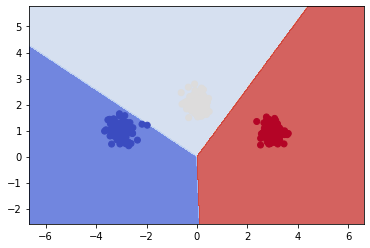

In [7]:
#Test the OneVsAllClassifier
from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X,y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet

#Create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

from sklearn import metrics
metrics.confusion_matrix(y, clf_onevsall.predict(X))

# Multiclass SVM

In [9]:
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)


def featureMap(X,y,num_classes) :
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    #The following line handles X being a 1d-array or a 2d-array
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
        
    #Construct zero vectors of dimension (num_samples*num_inFeatures)
    num_outFeatures = num_classes * num_inFeatures
    output_X = np.zeros(num_samples * num_outFeatures).reshape(num_samples, num_outFeatures)
    
    #Create a method for num_samples == 1
    if num_samples == 1:
        feature_mapped = np.zeros(num_outFeatures)
        feature_mapped[y * num_inFeatures:(y + 1) * num_inFeatures] = X
        return feature_mapped
        
    #Loop through various indices and samples in X
    for idx,sample in enumerate(X):
        yi = y[idx]
        feature_mapped = np.zeros(num_outFeatures)
        feature_mapped[yi * num_inFeatures:(yi + 1) * num_inFeatures] = sample
        output_X[idx,:] = feature_mapped
    return output_X
    
    
def sgd(X, y, num_outFeatures, subgd, eta = 0.1, T = 10000):
    '''
    Runs subgradient descent, and outputs resulting parameter vector.
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y,w and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    num_samples = X.shape[0]
    
    #Create zero vectors for w and avg_w
    w = np.zeros(num_outFeatures)
    avg_w = np.zeros(num_outFeatures)
    
    #Loop through all values in T
    for t in range (T):
        
        #Generate random value up to 300
        pos = np.random.randint(300)
        
        #Assign x and y values based on random value
        x_sample = X[pos]
        y_sample = y[pos]
        
        #Use subgd function on random x and y values
        vt = subgd(x_sample,y_sample,w) # using both version of subgradient works
        w = w - eta * vt
        avg_w = avg_w +  w
        
    #Calculate and return weights
    weights = avg_w / T
    return weights


class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, num_outFeatures, lam=1.0, num_classes=3, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.num_outFeatures = num_outFeatures
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.fitted = False
    
    def subgradient(self,x,y,w):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''        
        #Calculate loss function
        loss = [self.Delta(y, y_prime) + w.dot(self.Psi(x, y_prime) - w.dot(self.Psi(x, y)))\
               for y_prime in range(self.num_classes)]
        
        #Calculate predictions
        y_hat = np.where(loss == max(loss))[0][0]
        
        #Calculate and return subgradient_vector
        subgrad_term_1 = 2 * self.lam * w.T
        subgrad_term_2 = self.Psi(x, y_hat)
        subgrad_term_3 = self.Psi(x, y)
        subgradient_vector = subgrad_term_1 + subgrad_term_2 - subgrad_term_3
        return subgradient_vector
    
    def fit(self,X,y,eta=0.1,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        self.coef_ = sgd(X,y,self.num_outFeatures,self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
        
        #Calculate number of samples
        n_samples = len(X)
        
        #Initialize scores with zeros
        scores = np.zeros(n_samples * self.num_classes).reshape(n_samples, self.num_classes)
            
        #Loop through each sample and assign scores    
        for i,x_i in enumerate(X):
            scores[i,:] = [self.coef_.dot(self.Psi(x_i,y_i)) for y_i in range(self.num_classes)]
        return scores
            
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''        
        #Define function to determine maximum indices 
        def maximum_position(array):
            return np.where(array == max(array))[0][0]
        
        #Apply decision funcion to X
        dec_func = self.decision_function(X)
        
        #Predict classes using previously defined maximum position function
        predicted_classes = np.apply_along_axis(func1d = maximum_position, axis = 1, arr = dec_func)
        return predicted_classes

w:
[-0.29422556 -0.05284238 -0.00136812  0.10902631  0.29559368 -0.05618393]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

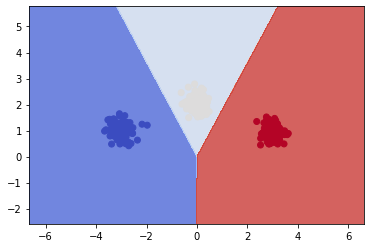

In [30]:


#the following code ests the MulticlassSVM and sgd
#will fail if MulticlassSVM is not implemented yet
est = MulticlassSVM(6,lam=1)
est.fit(X,y,eta=0.1)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


from sklearn import metrics
metrics.confusion_matrix(y, est.predict(X))